In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve,
   confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, f1_score)
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Table of Contents
*need to do*

# Introduction
*need to do*

# Data

The dataset I chose for the project can be found here on Kaggle. https://www.kaggle.com/itssuru/loan-data  The data was provided by Kaggle user ItsSuru.  It is a loan data dataset gathered from publicly available data from LendingClub.com.  The intent of the data is to create a model to predict whether or not a borrower will pay back their loan in full.

The data consists of 9,568 observations and 14 features.

In [39]:
df = pd.read_csv('data/loan_data.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


The first five observations can be observed below

In [41]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## Meaning of the features

* credit.policy - credit policy, wether or not the client meets the credit underwriting criteria for Lending Club.  Boolean value, 1 for yes, 0 for no.
* purpose - the purpose of the loan

In [42]:
df.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

* int.rate - the interest rate of the loan
* installment - the monthly installments owed
* log.annual.inc - the log of the borrowers annual income
* dti - the debt to income ratio of the borrower
* fico - the borrowers FICO score
* days.with.cr.line - the number of days the borrower has had a credit line
* revol.bal - revolving balance, the amount unpaid by the borrower at the end of their credit cycle
* revol.util - revolving utilization rate, the amount of credit used relative to their credit limit
* inq.last.6mths - the number of inquiries the borrower has had by creditors in the past six months
* delinq.2yrs - the number of times the borrow has been thirty or more days past due in the last two years
* pub.rec - the number of derogitory public records of the borrower
* not.fully.paid - a boolean depicting if the loan is not fully paid, 1: the loan is not fully paid, 0: the loan is fully paid

In [43]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


## Feature preparation

for ease of use, I am replacing the period in the feature names with an underscore.  I am also replacing the not fully paid column with a fully paid column as it makes interpreting analysis and visualizations easier.  Plus I would think the lending company would be more intereted in wether or not a borrower will fully pay than if they will not fully pay..  However not being in the finance industry, I may be wrong.

In [44]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [45]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid',axis=1,inplace=True)

# Exploratory Data Analysis

## Target column - fully paid

In [46]:
df.fully_paid.value_counts()

1    8045
0    1533
Name: fully_paid, dtype: int64

<AxesSubplot:xlabel='fully_paid', ylabel='count'>

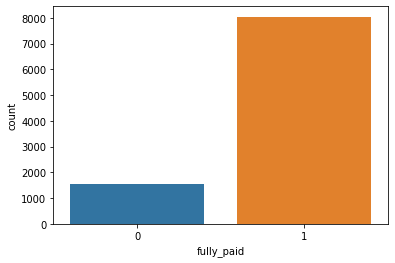

In [47]:
sns.countplot(x=df.fully_paid)

As you can see in the dataset, there is definite inbalance in the target value of fully paid.  when creating a model I will probably need to deal with the imbalance.  

Methods of dealing with imbalance implimented in this project
* Random undersampling and oversampling
* Using class weights: balanced for ml algorithms with the option
* Moving the classification threshold

## Checking for missing values

In [48]:
df.isnull().sum()

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
fully_paid           0
dtype: int64

There appears to be no null values.  Now, from the descriptive statistics above, zeros for any numerical, non oridinal, feature, such as dti, may represent missing values.  

In [49]:
may_be_missing = []
keys = df.describe().keys()
for i in range(1,len(keys)-1):
    if df.describe().loc['min',keys[i]]==0:
        may_be_missing.append(keys[i])
may_be_missing

['dti', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']

For these possibly missing values, I'm going to create a posmiss feature

In [50]:
for val in may_be_missing:
    df[val+'_possmiss'] = 1*(df[val]==0)

## Looking at individual features

### Credit Policy

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

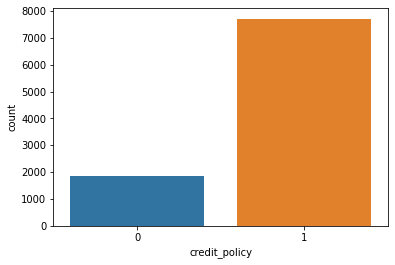

In [51]:
sns.countplot(x = 'credit_policy', data = df)

More borrowers meet the credit policy than not

### Purpose

<AxesSubplot:xlabel='count', ylabel='purpose'>

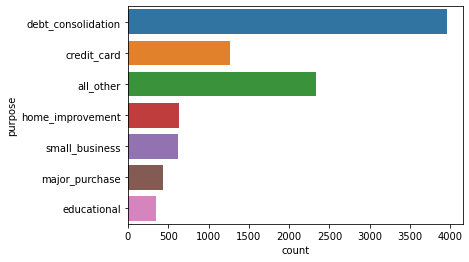

In [52]:
sns.countplot(y=df.purpose)

The majority of borrowers are taking a loan out for debt consolidation

### Histograms of the remaining numeric features

In [53]:
features = ['int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec']

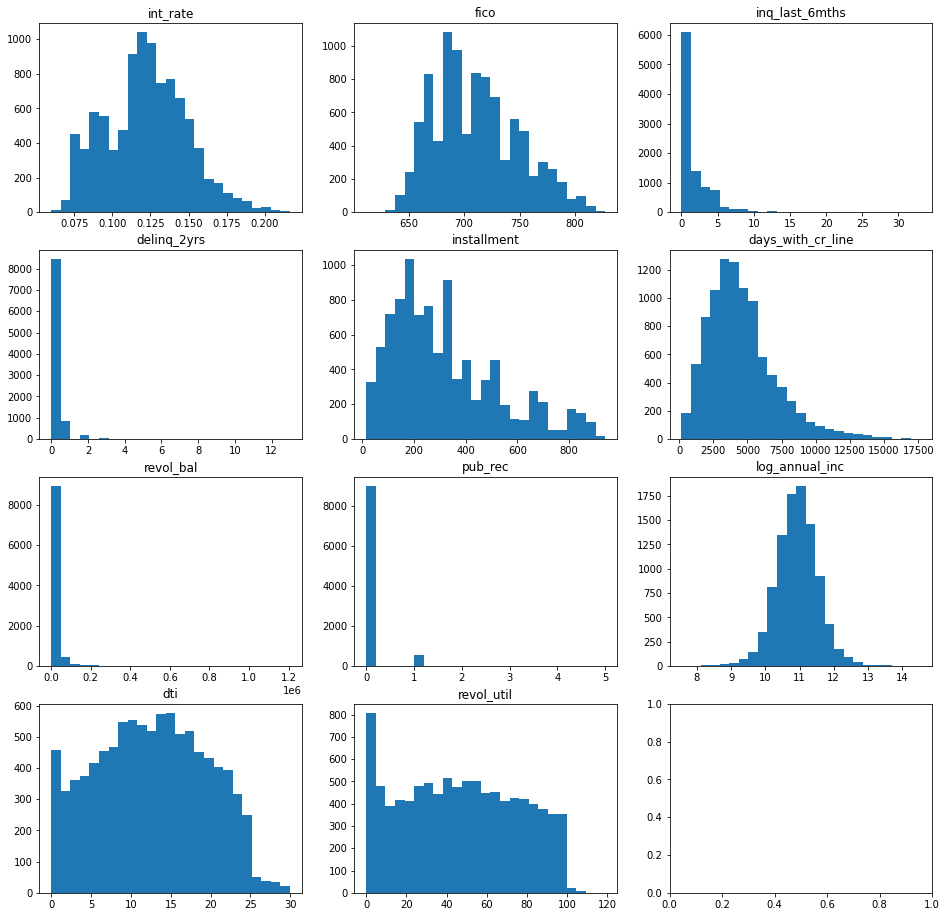

In [54]:
fig, axs = plt.subplots(4,3,figsize=[16,16])
r, c = (0,0)
for f in features:
    axs[r,c].hist(df[f], bins=25)
    axs[r,c].set_title(f)
    r = (r+1)%4
    c = (c+1)%3

Only log annual income looks somewhat normal although it does stretch.  It may need to be winsorized.  Days with credit line looks Poisson.  

## Looking at features with respect to fully paid

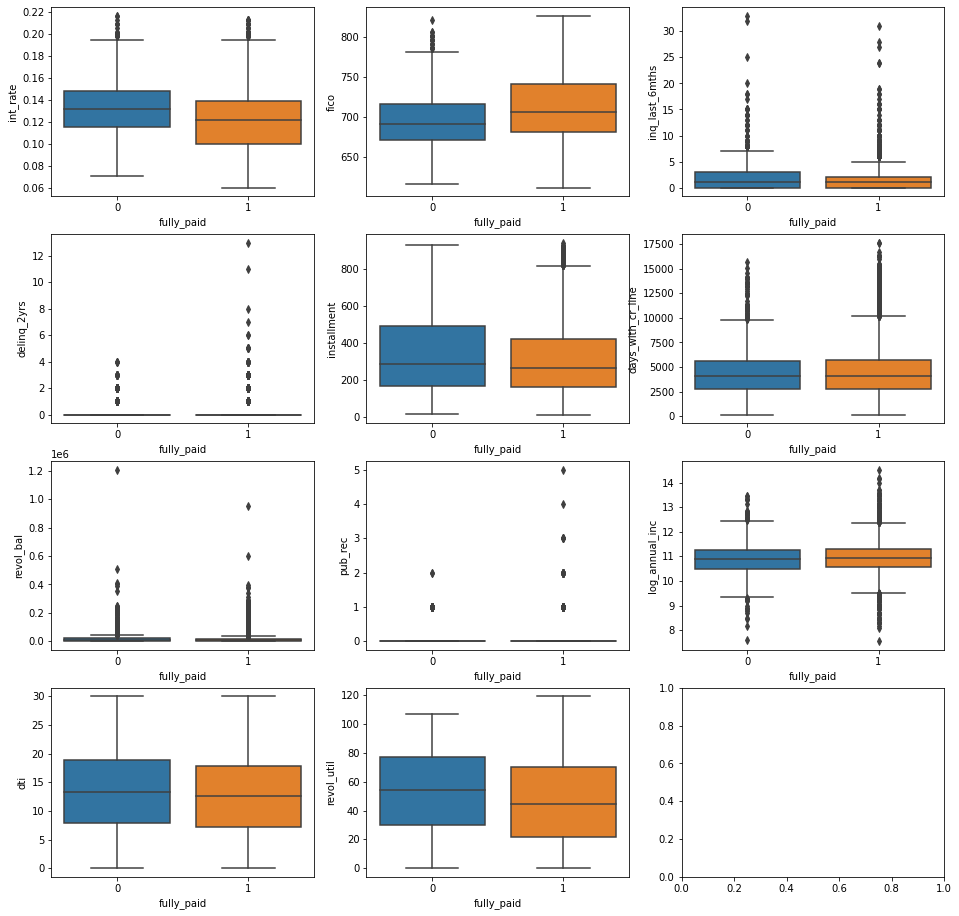

In [55]:
fig, axs = plt.subplots(4,3,figsize=[16,16])
r, c = (0,0)
for f in features:
    sns.boxplot(x='fully_paid',y=f,data=df, ax=axs[r,c])
    r = (r+1)%4
    c = (c+1)%3

From the bar charts it can be noted interest rate is slightly higher for those that have not fully paid as well as revol_util.  The rest are relatively similar.  Also there are definite outliers.  When working with linear models I will want to curb some maximum values.

When comparing categorical or ordinal counts with respect to wether the loan is fully paid or not, it is difficult to make interpretations using the imbalanced fully_paid.  Therefore I took a subsample to use with charts.

In [56]:
paid=df[df.fully_paid==1]
not_paid =df[df.fully_paid==0]
paid_subsample = paid.sample(n=1000, random_state=675)
not_paid_subsample = not_paid.sample(n=1000, random_state=675)
original_subsample = pd.concat([paid_subsample,not_paid_subsample])

### Credit policy

<AxesSubplot:xlabel='credit_policy', ylabel='count'>

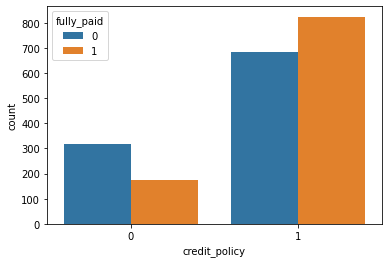

In [57]:
sns.countplot(x = 'credit_policy', hue = 'fully_paid', data = original_subsample)


For those that met the credit policy, more have fully paid.  Those that have not met the credit policy, more have not fully paid.

### Purpose

<AxesSubplot:xlabel='purpose', ylabel='count'>

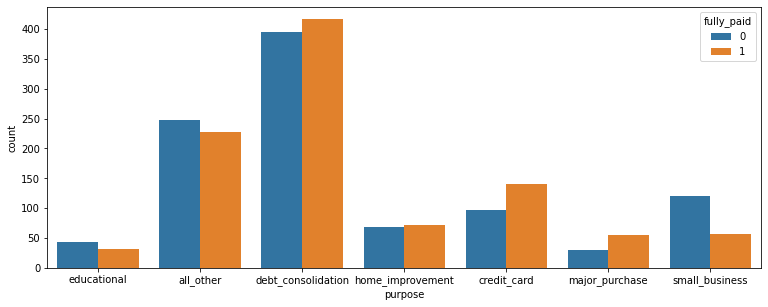

In [58]:
fig, ax = plt.subplots(figsize=(12.8,4.8))
sns.countplot(x='purpose',hue='fully_paid',data=original_subsample)

Those taking out loans for debt consolidation, home improvement, credit card payment, and major purposes appear more likely to fully pay.  Personal note: I'm still workinng on paying back my college loans twenty years later so I can see how for educational loans, more are not fully paid

## Looking for correlation

<AxesSubplot:>

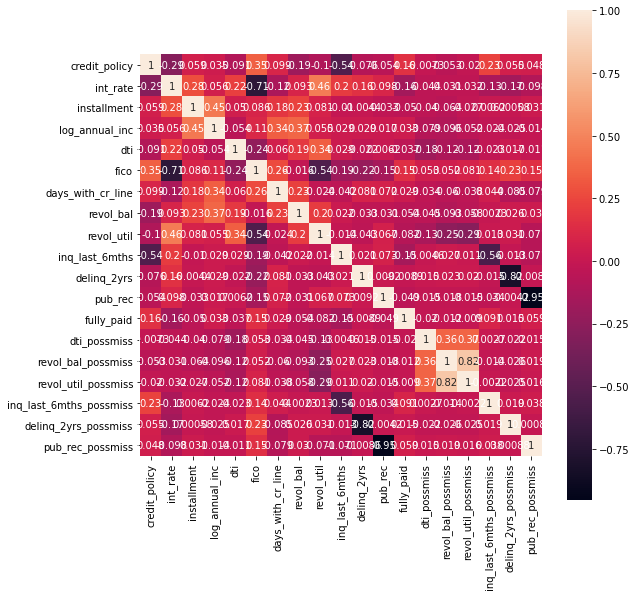

In [59]:
loan_corr = df.select_dtypes(exclude='object').corr()
f = plt.figure(figsize=(9,9))
sns.heatmap(loan_corr,square=True,annot=True)

The only strong correlation appears between wether revolving balance or revolving utilities are missing.  When working with a linear model, I will exclude these.

# Model creation

The algorithms I chose to create machine learning models to predict loan repayment are:

* K Nearest Neighbors
* Random Forests
* Logistic regressions

I feel these three algorithms will offer a variety of models.  Logistic regression is a good binary classifier.  Random forests is an ensemble learning algorithm using decision trees.  This is robost to outliers but sensitive to imbalance and so will definitely need to handle imbalance.  K nearest neighbors is a similarity classifier that is good for data for which linear models may not fit.

## Evaluation metric

To evaluate the model I chose to use F1 score along with looking at the precision and recall.  As the data is imbalanced, accurcy is not a good metric to use.  F1 is a balance of precision and recall.

In the buisness sense, a lower precision would mean more clients that will not fully pay back their loan are being predicted as paying their loan back.  The lender could lose money by enrolling these clients. Whereas a low recall would mean more people that will fully pay their loan back are being predicted as not paying their loan back.  A potential consequence of this loss of potential clients, some potential clients could be turned down.

Using precision alone or recall alone is not advisable as, for example, I could predict positive for every observation and get 100 percent precision.  F1 is a balance of the two and I feel is good to use for the evaluation metric.

## Functions I defined to assist

In [60]:
def get_preds(classifier, X_test, y_test, threshold):
    """
    gets the predicted y values when the threshold
    is not the standard 0.5
    """
    y_preds = classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds = 1 * (y_preds > threshold)
    return y_preds    

In [61]:
def find_threshold(estimator, X_train, y_train, scoring='f1'):
    """
    finds the optimum threshold for moving the classification threshold
    """
    best_thresholds=[0]*5
    scores = cross_validate(estimator, X_train, y_train, scoring = scoring, return_estimator=True)
    for i in range(5):
        estimator_i = scores['estimator'][i]
        yhat = estimator_i.predict_proba(X_train)
        yhat = yhat[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train,yhat)
        fscores = 2*precision*recall/(precision+recall)
        ix = np.argmax(fscores)
        best_thresholds[i] = thresholds[ix]
    return np.mean(best_thresholds)

In [62]:
def get_f1(classifier, X, y, threshold=None):
    """
    Returns the f1 score. This function needed to be created because of
    moving the classification threshold
    """
    if threshold is None:
        y_preds = classifier.predict(X)
    else:
        y_preds = get_preds(classifier, X, y, threshold)
    return f1_score(y, y_preds)

In [63]:
def print_accuracy_results(y_true, y_preds):
    """
    Predicts the percntage of positive values correctly predicted
    and the percentage of negative values correctly predicted.
    I realize now I could have done this better using Sklearn's
    Confusion Matrix and setting normalize to 'true'.
    """
    correct_classification = 1 - np.absolute(y_true - y_preds)
    scores_df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = scores_df[scores_df.y_values == 0]
    ones = scores_df[scores_df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [64]:
def print_scores(classifier, X_test, y_test, threshold=None, beta=1.0, accur=False):
    """
    Prints the precision, recall, f1 scores, and if asked, calls print_accuracy_results
    """
    if threshold is None:
        y_preds = classifier.predict(X_test)
    else:
        y_preds = get_preds(classifier, X_test, y_test, threshold)
        
    scores = precision_recall_fscore_support(y_preds, y_test, beta=beta, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    if accur:
        print('-'*50)
        print_accuracy_results(y_test, y_preds)

## Splitting the data

In [65]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

## K nearest neighbors

### Base model

In [67]:
numeric_columns = ['int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
cat_column = ['purpose']

As KNN is sensitive to scale, the numeric values need to be scaled.  In addition, the one categorical variable needs to be one hot encoded.

In [68]:
numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

In [69]:
preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_columns),
    ('cat',cat_transformer,cat_column)],
    remainder = 'passthrough')

In [70]:
knn1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_classifier', KNeighborsClassifier())])

In [71]:
knn1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  ['int_rate', 'installment',
                                                   'log_annual_inc', 'dti',
                                                   'fico', 'days_with_cr_line',
                                                   'revol_bal', 'revol_util',
                                                   'inq_last_6mths',
                                                   'delinq_2yrs', 'pub_rec']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_un

In [72]:
get_f1(knn1,X_train,y_train)

0.9198748271595953

The f1 score on the training set is 0.91.  This will be compared to the f1 score on the test set to see if there is any overfitting or underfitting.

In [73]:
print_scores(knn1, X_test, y_test)

precision score:  0.9616573902288188
recall score:  0.8441910966340934
f1 score:  0.8991037872217404


The f1 score on the test set slightly dropped.  No overfitting or underfitting is apparent.  The base model heavily predicts the positive target.  This is probably due to the imbalance.  

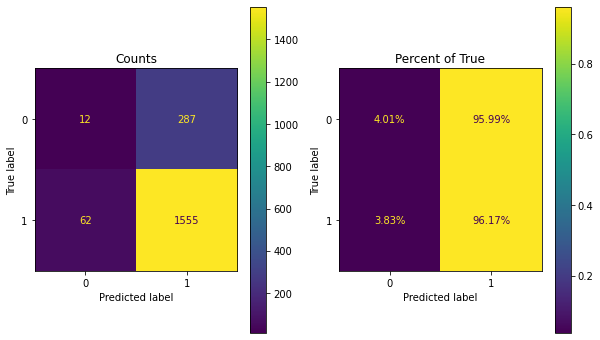

In [113]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(knn1 ,X_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(knn1 ,X_test, y_test, ax = axs[1], normalize='true', values_format='.2%')


The effect of the imbalanced set can be seen on the confusion matrix.

### Moving the classification threshold

In [75]:
find_threshold(knn1, X_train, y_train)

0.6

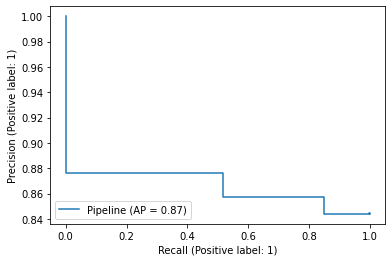

In [106]:
plot_precision_recall_curve(knn1 ,X_test, y_test)

Moving the threshold from 0.5 to 0.6 does not noticeably change precision and recall as seen by this graph.

In [76]:
get_f1(knn1,X_train,y_train, threshold=0.6)

0.9039565798788641

In [77]:
print_scores(knn1, X_test, y_test, threshold=0.6, accur=True)

precision score:  0.8503401360544217
recall score:  0.8572319201995012
f1 score:  0.8537721204594846
--------------------------------------------------
The percentage of fully_paid predicted correctly:  85.03401360544218
The percentage of not fully_paid predicted correctly:  23.411371237458194


Notice the accuracy scores are a little better.

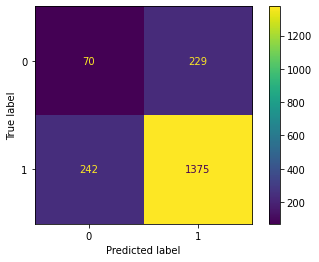

In [78]:
y_preds = get_preds(knn1, X_test, y_test, threshold=0.6)
knn1_cm = confusion_matrix(y_test, y_preds)
cm_disp = ConfusionMatrixDisplay(knn1_cm, display_labels=knn1.classes_)
cm_disp.plot()

Moving the threshold reduces the number of true positives, increases the numbeer of true negatives, reduces the number of false positives and increases the number of false negatives.  The f1 score slightly decreases.

### Base model with undersampling

In [79]:
knn2 = imbPipeline(steps =[
    ('preprocessor',preprocessor),
    ('sampler',RandomUnderSampler(random_state=625)),
    ('knn_classifier', KNeighborsClassifier())])

In [80]:
knn2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  ['int_rate', 'installment',
                                                   'log_annual_inc', 'dti',
                                                   'fico', 'days_with_cr_line',
                                                   'revol_bal', 'revol_util',
                                                   'inq_last_6mths',
                                                   'delinq_2yrs', 'pub_rec']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_un

In [81]:
get_f1(knn2,X_train,y_train)

0.7658227848101266

In [82]:
print_scores(knn2, X_test, y_test)

precision score:  0.6072974644403216
recall score:  0.8598949211908932
f1 score:  0.7118521203334542


The f1 scores are similar so no overfitting or underfitting is apparent.  Undersampling does better at balancing the number of true positives and true negatives but at the cost of f1.  

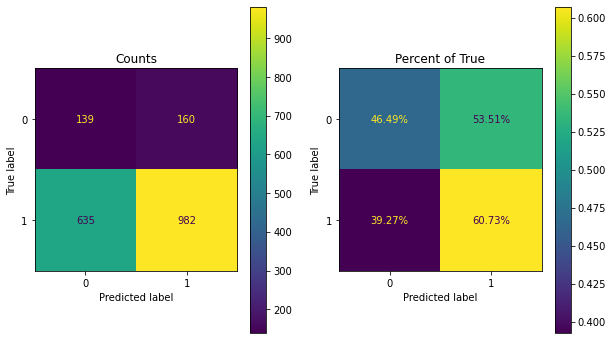

In [112]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(knn2 ,X_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(knn2 ,X_test, y_test, ax = axs[1], normalize='true', values_format='.2%')

As can be seen there are many more incorrect predictions using a subsample.  I am going to try to improve this sample with hyperparameter tuning.

### Undersampling and hyperparameter tuning

In [84]:
params = {
    'knn_classifier__weights':['uniform', 'distance'],
    'knn_classifier__n_neighbors':[2,3,5,7,10]
}

In [85]:
grid1 = GridSearchCV(knn2,params,scoring='f1')
grid1.fit(X_train,y_train)
grid1.best_params_

{'knn_classifier__n_neighbors': 10, 'knn_classifier__weights': 'distance'}

In [86]:
grid1.best_score_

0.7344696993745067

In [87]:
print_scores(grid1.best_estimator_, X_test, y_test)

precision score:  0.6468769325912183
recall score:  0.8716666666666667
f1 score:  0.7426340078097267


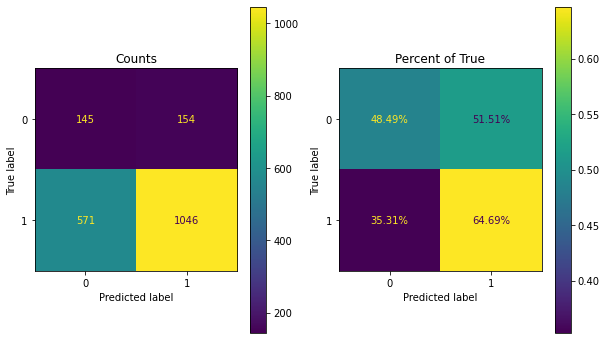

In [111]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(grid1.best_estimator_ ,X_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(grid1.best_estimator_ ,X_test, y_test, ax = axs[1], normalize='true', values_format='.2%')


Using hyperparameter tuning, all metrics have increased from the undersampling without hyperparameter tuning.  In fact the recall score has increased from the model with the classification threshold moved.  However f1 and precision are still lower.  As can be seen, performance is better without hyperparameter tuning.

### Base model with Oversampling

In [89]:
knn3 = imbPipeline(steps =[
    ('preprocessor',preprocessor),
    ('sampler',RandomOverSampler(random_state=625)),
    ('knn_classifier', KNeighborsClassifier())])

In [90]:
knn3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  ['int_rate', 'installment',
                                                   'log_annual_inc', 'dti',
                                                   'fico', 'days_with_cr_line',
                                                   'revol_bal', 'revol_util',
                                                   'inq_last_6mths',
                                                   'delinq_2yrs', 'pub_rec']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_un

In [91]:
get_f1(knn3,X_train,y_train)

0.8690642458100558

In [92]:
print_scores(knn3, X_test, y_test)

precision score:  0.6821273964131107
recall score:  0.8691883372734437
f1 score:  0.7643797643797644


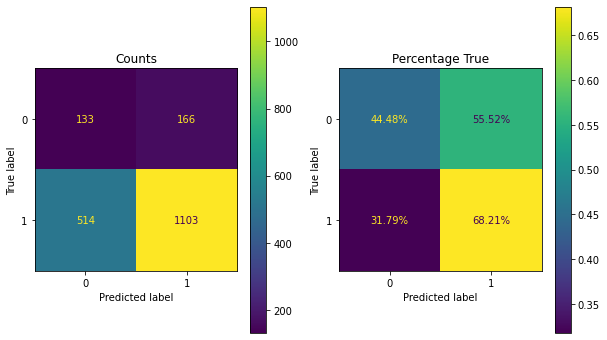

In [110]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(knn3 ,X_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(knn3 ,X_test, y_test, ax = axs[1], normalize='true', values_format='.2%')

With respect to precision, recall, and f1, oversampling performed better than undersampling.  However the test set f1 score is moderately lower than than training set f1 score.  This model may be overfitting.

### Oversampling and hyperparameter tuning

In [94]:
grid2 = GridSearchCV(knn3,params,scoring='f1')
grid2.fit(X_train,y_train)
grid2.best_params_

{'knn_classifier__n_neighbors': 2, 'knn_classifier__weights': 'distance'}

In [95]:
grid2.best_score_

0.8618570801682122

In [96]:
print_scores(grid2.best_estimator_, X_test, y_test)

precision score:  0.8620902906617193
recall score:  0.8469015795868773
f1 score:  0.8544284400858106


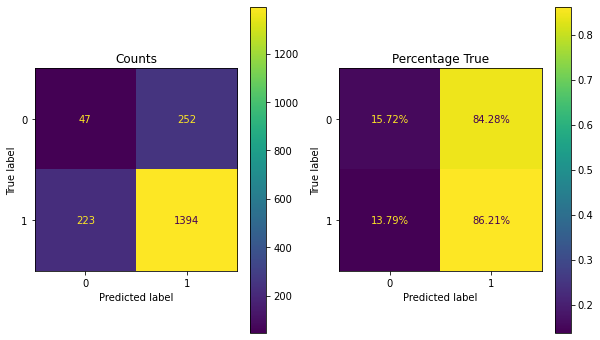

In [109]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(grid2.best_estimator_ ,X_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(grid2.best_estimator_ ,X_test, y_test, ax = axs[1], normalize='true', values_format='.2%')

This model does not seem to overfit like the model without hyperparameter tuning.  However, again, it favors the majority.

### KNN Comparisons

*need to finish*

## Random Forests

### Ordinal encoding the one categorical variable and splitting the data

In [116]:
X_rf = X.copy()
le = LabelEncoder()
X_rf['purpose'] = le.fit_transform(X.purpose.values)
Xrf_train, Xrf_test, y_train, y_test = train_test_split(X_rf, y, random_state=675, test_size=0.2)

### Base model

In [119]:
rf1 = RandomForestClassifier()
rf1.fit(Xrf_train,y_train)

RandomForestClassifier()

In [121]:
print_scores(rf1, Xrf_test, y_test)

precision score:  0.9913419913419913
recall score:  0.8468040147913365
f1 score:  0.9133903133903135


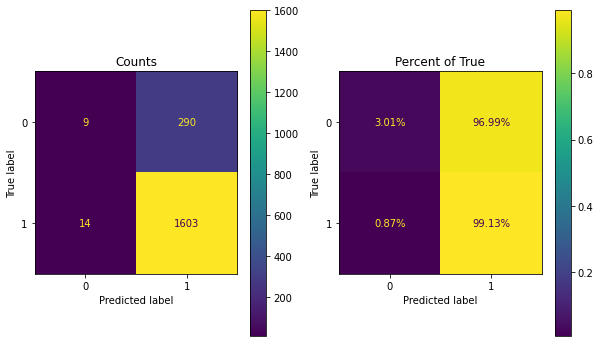

In [122]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].set_title("Counts")
plot_confusion_matrix(rf1 ,Xrf_test, y_test, ax = axs[0])
axs[1].set_title("Percent of True")
plot_confusion_matrix(rf1 ,Xrf_test, y_test, ax = axs[1], normalize='true', values_format='.2%')

As can be seen with the base model of KNN, imbalance is causing the model to mostly predict positive.

### Looking at feature importance

<AxesSubplot:>

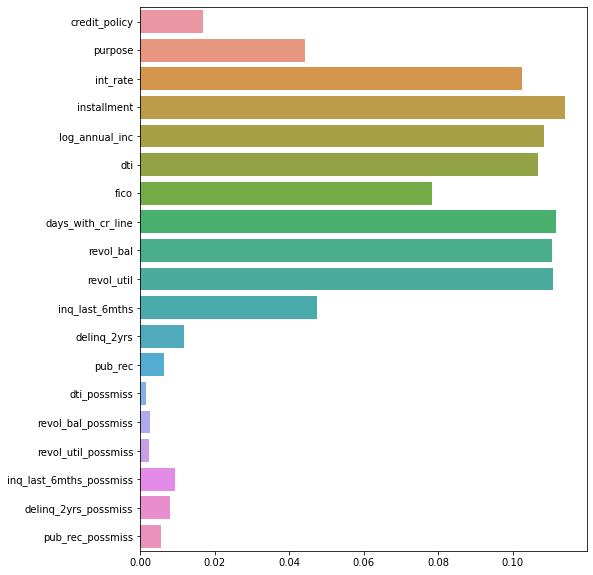

In [129]:
f = plt.figure(figsize=(8,10))
sns.barplot(y=X.columns, x=rf1.feature_importances_)